In [1]:
import numpy as np
import os
import random
import torch
import torch.nn.functional as F
from torch import nn

from google_drive_downloader import GoogleDriveDownloader as gdd
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
%matplotlib inline

if not os.path.isdir('./omniglot_resized'):
  gdd.download_file_from_google_drive(file_id='1iaSFXIYC3AB8q9K_M-oVMa4pmB7yKMtI',dest_path='./omniglot_resized.zip',unzip=True)
assert os.path.isdir('./omniglot_resized')

### load data

In [2]:
#@title DataGenerator(N,K,config,device)
def get_images(paths, labels, nb_samples=None, shuffle=True):
    """
    Takes a set of character folders and labels and returns paths to image files
    paired with labels.
    Args:
        paths: A list of character folders
        labels: List or numpy array of same length as paths
        nb_samples: Number of images to retrieve per character
    Returns:
        List of (label, image_path) tuples
    """
    if nb_samples is not None:
        sampler = lambda x: random.sample(x, nb_samples)
    else:
        sampler = lambda x: x
    images_labels = [(i, os.path.join(path, image))
                     for i, path in zip(labels, paths)
                     for image in sampler(os.listdir(path))]
    if shuffle:
        random.shuffle(images_labels)
    return images_labels


def image_file_to_array(filename, dim_input):
    """
    Takes an image path and returns numpy array
    Args:
        filename: Image filename
        dim_input: Flattened shape of image
    Returns:
        1 channel image
    """
    import imageio
    image = imageio.imread(filename)
    image = image.reshape([dim_input])
    image = image.astype(np.float32) / 255.0
    image = 1.0 - image
    return image


class DataGenerator(object):
    """
    Data Generator capable of generating batches of Omniglot data.
    A "class" is considered a class of omniglot digits.
    """

    def __init__(self, num_classes, num_samples_per_class, config={}, device = torch.device('cpu')):
        """
        Args:
            num_classes: int
                Number of classes for classification (N-way)
            
            num_samples_per_class: int
                Number of samples per class in the support set (K-shot).
                Will generate additional sample for the querry set.
                
            device: cuda.device: 
                Device to allocate tensors to.
        """
        self.num_samples_per_class = num_samples_per_class
        self.num_classes = num_classes

        data_folder = config.get('data_folder', './omniglot_resized')
        self.img_size = config.get('img_size', (28, 28))

        self.dim_input = np.prod(self.img_size)
        self.dim_output = self.num_classes

        character_folders = [os.path.join(data_folder, family, character)
                             for family in os.listdir(data_folder)
                             if os.path.isdir(os.path.join(data_folder, family))
                             for character in os.listdir(os.path.join(data_folder, family))
                             if os.path.isdir(os.path.join(data_folder, family, character))]

        random.seed(1)
        random.shuffle(character_folders)
        num_val = 100
        num_train = 1100
        self.metatrain_character_folders = character_folders[: num_train]
        self.metaval_character_folders = character_folders[
            num_train:num_train + num_val]
        self.metatest_character_folders = character_folders[
            num_train + num_val:]
        self.device = device

    def sample_batch(self, batch_type, batch_size):
        """
        Samples a batch for training, validation, or testing
        Args:
            batch_type: str
                train/val/test set to sample from
                
            batch_size: int:
                Size of batch of tasks to sample
                
        Returns:
            images: tensor
                A tensor of images of size [B, K+1, N, 784]
                where B is batch size, K is number of samples per class, 
                N is number of classes
                
            labels: tensor
                A tensor of images of size [B, K+1, N, N] 
                where B is batch size, K is number of samples per class, 
                N is number of classes
        """
        if batch_type == "train":
            folders = self.metatrain_character_folders
        elif batch_type == "val":
            folders = self.metaval_character_folders
        else:
            folders = self.metatest_character_folders

        #############################
        #### YOUR CODE GOES HERE ####
        #############################
       
    
        N=self.num_classes
        K=self.num_samples_per_class
        B=batch_size

        images=torch.zeros(B,N,K+1,784,dtype=torch.float32)
        labels=torch.zeros(B,N,K+1,N,dtype=torch.float32)
        
        # random.seed(5533)
        for b in range(B):
            task_folders=[folders[random.randint(0, len(folders)-1)] for i in range(N)]

            task_images=torch.zeros(N,K+1,784,dtype=torch.float32)
            task_labels=torch.zeros(N,K+1,N,dtype=torch.float32)
            for class_index,class_path in enumerate(task_folders):
                imgs_paths=os.listdir(class_path)
                # 从imgs_paths 选择K+1个路径 ，这里考虑不放回
                K_imgs_paths=[os.path.join(class_path, imgs_paths[r]) for r in random.sample(list(range(len(imgs_paths))),K+1)]
                #归一化处理？？
                task_images[class_index]=torch.stack([torch.tensor(image_file_to_array(p,28*28)) for p in K_imgs_paths])
                task_labels[class_index]= torch.nn.functional.one_hot(torch.tensor(class_index), num_classes=N)

            idx=list(range(N))
            sh_idx=idx[:]
            random.shuffle(sh_idx)

            task_images[idx,K]=task_images[sh_idx,K]
            task_labels[idx,K]=task_labels[sh_idx,K]
            images[b]=task_images
            labels[b]=task_labels
        images.transpose_(1, 2)
        labels.transpose_(1, 2)
        return images.to(self.device),labels.to(self.device)
        # SOLUTION:


In [3]:
#@title show_data(taski,images,labels)
def show_data(index,images,labels):
  K=labels.shape[1]-1
  N=labels.shape[2]

  task_images,task_labels=images[index],labels[index]

  plt.figure(figsize=(15,15))
  _,axes=plt.subplots(1+K,N)
  for k in range(1+K):
    n_images=task_images[k].view(N,28,28).cpu().detach()
    n_labels=task_labels[k].argmax(dim=-1).cpu().detach()

    assert tuple(n_images.shape)==(N,28,28)
    assert tuple(n_labels.shape)==(N,)
    
    for n in range(N):
      im,lb=n_images[n],n_labels[n]
      axes[k,n].imshow(im,cmap="gray")
      axes[k,n].axis('off')
      prefix='pred' if k==K else ''
      axes[k,n].set_title(f"{prefix}  C: {lb.item()}")


In [4]:
#@title plot_result(steps,train_loss_history,test_loss_history,acc_history,config):
def plot_result(steps,train_loss_history,test_loss_history,acc_history,config):
  _,axes=plt.subplots(2,1)
  print(config)
  axes[0].plot(steps,train_loss_history,label='trainloss')
  axes[0].plot(steps,test_loss_history,label='valloss')
  axes[1].plot(steps,acc_history,label='acc')

  axes[0].legend()
  axes[1].legend()

  axes[0].set_title(f"{config.num_classes}_way-{config.num_samples}_shot_{config.training_steps}")

In [6]:
#@title
config={
    "num_classes":2,
    "num_samples":1,
    "meta_batch_size":128,
    "logdir":"run/log",
    "training_steps":10000,
    "log_every":100,
    "model_size":128
}
class MyClass():
  pass
my_instance = MyClass()
for key, value in config.items():
    setattr(my_instance, key, value)
config=my_instance
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

C:\Users\Administrator\AppData\Local\Temp\ipykernel_3048\890338642.py:35: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


<Figure size 1500x1500 with 0 Axes>

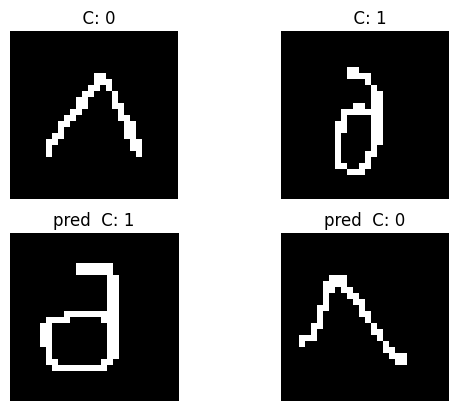

In [7]:
data_generator = DataGenerator(config.num_classes,config.num_samples, device=device)
images,labels=data_generator.sample_batch('train',32)
show_data(16,images,labels)

In [16]:
#@title MANN(N,K,hidden_size,input_size)
class MANN(nn.Module):

    def __init__(self, num_classes, samples_per_class, model_size=128, input_size=784):
        super(MANN, self).__init__()
        
        def initialize_weights(model):
            nn.init.xavier_uniform_(model.weight_ih_l0) #这是4个gate的W
            nn.init.xavier_uniform_(model.weight_hh_l0) #这是4个gate的W
            nn.init.zeros_(model.bias_hh_l0)  #这应该是初始cell输入？
            nn.init.zeros_(model.bias_ih_l0)  #这是4个gate的bias
    
        self.num_classes = num_classes
        self.samples_per_class = samples_per_class
        self.input_size = input_size
        self.hidden_size=model_size
        self.layer1 = torch.nn.LSTM(num_classes + input_size,model_size,batch_first=True)
        self.layer2 = torch.nn.LSTM(model_size,num_classes,batch_first=True)
        initialize_weights(self.layer1)
        initialize_weights(self.layer2)
    def forward_fix(self, input_images, input_labels):
        K=self.samples_per_class
        B=input_labels.shape[0]
        N=self.num_classes
        
        Dtrain=torch.cat((input_images[:,0:K,:,:],input_labels[:,0:K,:,:]),dim=3)
        Dtest=torch.cat((input_images[:,K:K+1,:,:],torch.zeros_like(input_labels[:,K:K+1,:,:])),dim=3)  
        
        # 修正,独立predict每个 test
        xtrain=Dtrain.view(B,K*N,Dtrain.shape[-1])
        y1,state_1=self.layer1(xtrain)
        assert tuple(y1.shape)==(B,K*N,self.hidden_size)
        y2,state_2=self.layer2(y1)
        assert tuple(y2.shape)==(B,K*N,N)
        
        xtext=Dtest.view(B,1*N,Dtest.shape[-1])
        
        logits=[]
        for n in range(N):
            y_test_1,_=self.layer1(xtext[:,n:n+1,:],state_1)
            y_test_2,_=self.layer2(y_test_1,state_2)  #(B,1,N)
            assert tuple(y_test_2.shape)==(B,1,N)
            logits.append(y_test_2[:,0,:])
        
        logits=torch.stack(logits,dim=1)    #(B,N,N)
        assert tuple(logits.shape)==(B,N,N)
        y2=torch.cat((y2,logits),dim=1)
        assert tuple(y2.shape)==(B,K*N+N,N)
        
        y2=y2.view(B,K+1,N,N)
        # 修正完成 
        return y2
        
    def forward(self, input_images, input_labels):
        return self.forward_fix( input_images, input_labels)
        """
        MANN
        Args:
            input_images: tensor
                A tensor of shape [B, K+1, N, 784] of flattened images
            
            labels: tensor:
                A tensor of shape [B, K+1, N, N] of ground truth labels
        Returns:
            
            out: tensor
            A tensor of shape [B, K+1, N, N] of class predictions
        """
        #############################
        #### YOUR CODE GOES HERE ####
        #############################
        K=self.samples_per_class
        B=input_labels.shape[0]
        N=self.num_classes
        
        # 剽窃的答案
        # input_labels_1=input_labels[:,0:K,:,:]
        # input_labels_2=torch.zeros_like(input_labels[:,K:K+1,:,:])
        # input_labels=torch.cat((input_labels_1,input_labels_2),dim=1)
        # x=torch.cat((input_images,input_labels),dim=3)
        # x=x.view(B,-1,x.shape[-1])
        #####

        #我的答案
        Dtrain=torch.cat((input_images[:,0:K,:,:],input_labels[:,0:K,:,:]),dim=3)
        Dtest=torch.cat((input_images[:,K:K+1,:,:],torch.zeros_like(input_labels[:,K:K+1,:,:])),dim=3)  
        x=torch.cat((Dtrain,Dtest),dim=1)
        x=x.view(B,-1,x.shape[-1])  #(K*N+N)
        #####
        
        
        ####################bug code####################
        # Dtrain=torch.cat([input_images[:,0:K,:,:],input_labels[:,0:K,:,:]],dim=3)
        # Dtest=torch.cat([input_images[:,K:K+1,:,:],torch.zeros_like(input_labels[:,K:K+1,:,:])],dim=3)

        
        # Dtrain= Dtrain.view(B,-1,Dtrain.shape[-1])
        # # bug 写成Dtest = Dtrain.view(B, -1, Dtest.shape[-1])
        # Dtest = Dtest.view(B, -1, Dtest.shape[-1])
        # # 先train 然后test排列，而不是 train,test交替排列
        # x=torch.cat((Dtrain,Dtest),dim=1)
        ####################
        
        # 
        y1, cells_1=self.layer1(x)


        # h0 = torch.zeros( 1,B, self.num_classes).to(device=input_labels.device)
        # c0 = torch.zeros( 1,B, self.num_classes).to(device=input_labels.device)
        y2,cells_2=self.layer2(y1)

        y2=y2.view(B,K+1,N,N)
        return y2
        # SOLUTION:


    def loss_function(self, preds, labels):
        """
        Computes MANN loss
        Args:
            preds: tensor
                A tensor of shape [B, K+1, N, N] of network outputs
            
            labels: tensor
                A tensor of shape [B, K+1, N, N] of class labels
                
        Returns:
            scalar loss
        """
        #############################
        #### YOUR CODE GOES HERE ####
        #############################
        N=self.num_classes
        logits=preds[:,-1,:,:]
        labels=labels[:,-1,:,:].argmax(dim=-1)
        
        logits=logits.transpose(1,2)

        loss=nn.functional.cross_entropy(logits,labels,reduction='mean')
        return loss
        # SOLUTION:        



In [17]:
def train_step(images, labels, model, optim):
    predictions = model(images, labels)
    loss = model.loss_function(predictions, labels)
    
    optim.zero_grad()
    loss.backward()
    optim.step()
    return predictions.detach(), loss.detach()


def model_eval(images, labels, model):
    predictions = model(images, labels)
    loss = model.loss_function(predictions, labels)
    return predictions.detach(), loss.detach()

In [18]:
def main(config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    writer = SummaryWriter(config.logdir)

    # Download Omniglot Dataset
    if not os.path.isdir('./omniglot_resized'):
        gdd.download_file_from_google_drive(file_id='1iaSFXIYC3AB8q9K_M-oVMa4pmB7yKMtI',
                                            dest_path='./omniglot_resized.zip',
                                            unzip=True)
    assert os.path.isdir('./omniglot_resized')

    # Create Data Generator
    data_generator = DataGenerator(config.num_classes,config.num_samples,device=device)

    # Create model and optimizer
    model = MANN(config.num_classes, config.num_samples, 
                 model_size=config.model_size)
    model.to(device)
    optim = torch.optim.Adam(model.parameters(), lr = 1e-3)
    

    steps,train_loss_history,test_loss_history,acc_history=[],[],[],[]

    for step in range(config.training_steps):
        images, labels = data_generator.sample_batch('train', config.meta_batch_size)
        _, train_loss = train_step(images, labels, model, optim)

        if (step + 1) % config.log_every == 0:
            images, labels = data_generator.sample_batch('test', 
                                                         config.meta_batch_size)
            pred, test_loss = model_eval(images, labels, model)
            pred = torch.reshape(pred, [-1, 
                                        config.num_samples + 1, 
                                        config.num_classes, 
                                        config.num_classes])
            pred = torch.argmax(pred[:, -1, :, :], axis=2)
            labels = torch.argmax(labels[:, -1, :, :], axis=2)
            
            
            
            trloss,tsloss,acc=train_loss.cpu().numpy(),test_loss.cpu(),pred.eq(labels).double().mean().item()
            print(f"{step}: trainLoss {trloss:.4f},test loss {tsloss:.4f}, acc:{acc:.3f}")
            steps.append(step)
            train_loss_history.append(trloss.item())
            test_loss_history.append(tsloss.item())
            acc_history.append(acc)

            writer.add_scalar('Train Loss', trloss, step)
            writer.add_scalar('Test Loss', tsloss, step)
            writer.add_scalar('Meta-Test Accuracy',acc,step)
    return (model,optim),steps,train_loss_history,test_loss_history,acc_history

In [19]:
(model,optim),steps,train_loss_history,test_loss_history,acc_history=main(config)

# save model
torch.save(
  dict(model_parameters=model.state_dict(),               
  optimizer_state_dict=optim.state_dict()),
  f"{config.num_classes}_way-{config.num_samples}_shot_{config.training_steps}.pt"
)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_3048\890338642.py:35: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


99: trainLoss 0.6714,test loss 0.6638, acc:0.656
199: trainLoss 0.5826,test loss 0.5849, acc:0.699
299: trainLoss 0.5442,test loss 0.5524, acc:0.707
399: trainLoss 0.4704,test loss 0.4678, acc:0.852
499: trainLoss 0.4590,test loss 0.4598, acc:0.840
599: trainLoss 0.4674,test loss 0.4775, acc:0.812
699: trainLoss 0.4637,test loss 0.4683, acc:0.816
799: trainLoss 0.4094,test loss 0.4291, acc:0.840
899: trainLoss 0.3874,test loss 0.4652, acc:0.801
999: trainLoss 0.4438,test loss 0.3763, acc:0.898
1099: trainLoss 0.3798,test loss 0.4445, acc:0.836
1199: trainLoss 0.3977,test loss 0.4177, acc:0.852
1299: trainLoss 0.4055,test loss 0.4463, acc:0.832
1399: trainLoss 0.3879,test loss 0.4449, acc:0.832
1499: trainLoss 0.3646,test loss 0.4334, acc:0.863
1599: trainLoss 0.4580,test loss 0.4143, acc:0.855
1699: trainLoss 0.4205,test loss 0.4363, acc:0.828
1799: trainLoss 0.3993,test loss 0.4189, acc:0.848
1899: trainLoss 0.3490,test loss 0.3929, acc:0.879
1999: trainLoss 0.3753,test loss 0.4115, a

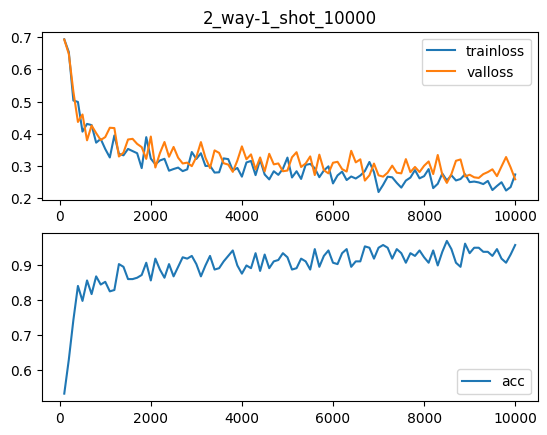

In [ ]:
plot_result(steps,train_loss_history,test_loss_history,acc_history,config)